In [ ]:
from model import Transformer, Encoder, Decoder, TConfig
from train import Trainer
import torch.utils.data as torchdata
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [6]:
config = TConfig(block_size = 24, 
                vocab_size = 500, 
                n_layer = 12,
                n_head = 12,
                n_embd = 48,
                dropout = 0.0,
                bias = True,
                padding_idx = 0)
encoder = Encoder(config)
decoder = Decoder(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
batch_size = 4
input = torch.randint(0, 500, (1, 24))
target = torch.randint(0, 500, (1, 24))
model = Transformer(encoder, decoder, config, device=device)
params = model.parameters()
logits, loss = model(input, target)
for p in model.parameters():
    p.requires_grad = True # autograd should record operations
out_shape = np.array(logits.shape)
print("Logits shape:", out_shape)
print('number of params:', len(list(params)))
print("Maximum loss:", -np.log(1/out_shape.sum()))

Using cpu device
total params: 1.36M		non-embedding params: 1.36M
Logits shape: [  1  24 500]
number of params: 346
Maximum loss: 6.263398262591624


I don't know what the issue here is!
Initially I thought that the learning rate depends on the model and irrespective of whethere the input and target where random or factual it will converge at an optimum learning rate. However that seems not to be the case. Rather, its dependent on the data as much

In [11]:
# lre = torch.linspace(-2,0, 1000)
# lre = torch.linspace(0,1, 1000)
lre = torch.linspace(1,5, 5000)
lrs = 10**lre  # a range of learning rates
epoch = 5000
step_i = []
lr_i = []
loss_i = []

for i in range(epoch):
    input = torch.randint(0, 500, (1, 24))
    target = torch.randint(0, 500, (1, 24))
    
    # Forward pass
    logits, loss = model(input, target)
    
    # Logging
    if i % 19 == 0:
        print(f"({i}/{epoch}) loss = {loss.item()}")
    
    # Backward pass
    model.zero_grad()  # This is a more efficient way to zero out gradients
    loss.backward()
    
    # Update
    for p in model.parameters():
        if p.grad is not None:  # Only update if gradient is not None
            p.data -= lrs[i] * p.grad
    
    # Track stats
    lr_i.append(lrs[i].item())
    step_i.append(i)
    loss_i.append(loss.item())

# Plotting (you may want to add this)
# import matplotlib.pyplot as plt
# plt.plot(lr_i, loss_i)
# plt.xscale('log')
# plt.xlabel('Learning rate')
# plt.ylabel('Loss')
# plt.show()

(0/5000) loss = 0.0002966517931781709
(19/5000) loss = 0.00029018099303357303
(38/5000) loss = 0.00024915047106333077
(57/5000) loss = 0.00025341581203974783
(76/5000) loss = 0.0002406635321676731
(95/5000) loss = 0.00023045383568387479
(114/5000) loss = 0.00020851912267971784
(133/5000) loss = 0.00020696014689747244
(152/5000) loss = 0.0001946790871443227
(171/5000) loss = 0.0001880046766018495
(190/5000) loss = 0.00017123900761362165
(209/5000) loss = 0.000168264246894978
(228/5000) loss = 0.00015984168567229062
(247/5000) loss = 0.0001569511223351583
(266/5000) loss = 0.00015298814105335623
(285/5000) loss = 0.00014436162018682808
(304/5000) loss = 0.00012582233466673642
(323/5000) loss = 0.0001294528046855703
(342/5000) loss = 0.00011882946273544803
(361/5000) loss = 0.00011481662659207359
(380/5000) loss = 0.00010553421452641487
(399/5000) loss = 0.00010772948007797822
(418/5000) loss = 0.00010795293928822502
(437/5000) loss = 0.00010237552487524226
(456/5000) loss = 9.73046044236

tensor(1.3121)


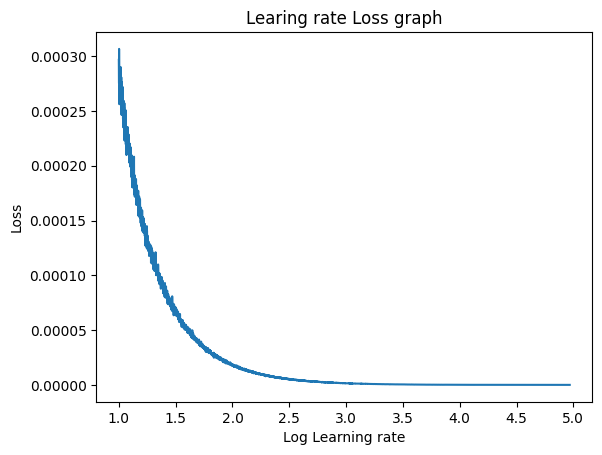

In [12]:
# after determine the optimum learning rate

with torch.no_grad():
    y = torch.tensor(loss_i)
    x = torch.log10(torch.tensor(lr_i))
    print(x[torch.argmin(y[:400])])
    plt.plot(x[:4960].numpy(), y[:4960].numpy())
    plt.xlabel('Log Learning rate')
    plt.ylabel('Loss')
    plt.title('Learing rate Loss graph')
    plt.show()

The equation: y = 0.000156 * e^(-2.855811*x-1.198546) + 0.000001


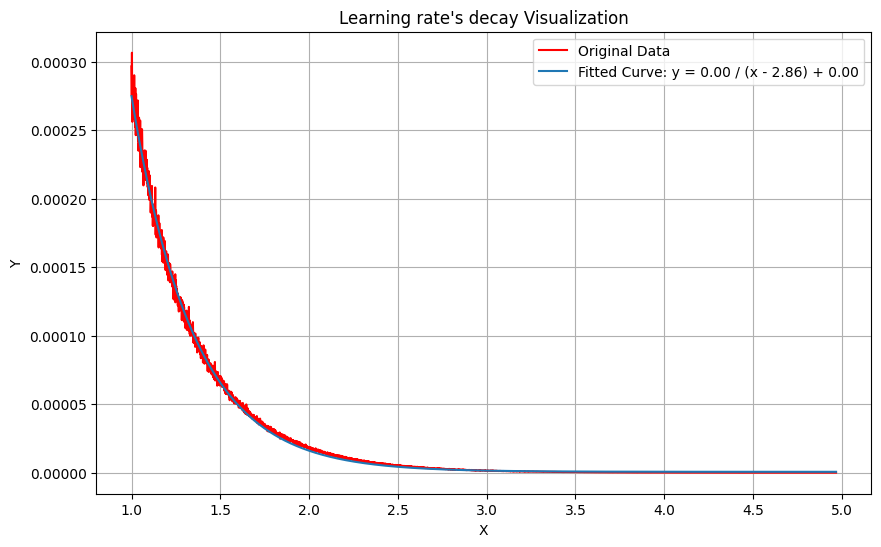

In [62]:
from scipy.optimize import curve_fit
def find_hyperbolic_equation(x, y):
    def hyperbola(x, a, b, c, d):
        return a * np.exp(-b * (x - d)) + c
    
    # Initial guess for parameters
    # p0 = [1, 0, 0]
    p0 = [max(y), 1, min(y), x[np.argmax(y)]]
    # Perform the curve fitting
    popt, _ = curve_fit(hyperbola, x, y, p0=p0)
    
    a, b, c, d = popt
    
    return a, b, c, d

X,Y = x[:4960], y[:4960]
a, b, c, d = find_hyperbolic_equation(X.numpy(), Y.numpy())
    
# Create a smooth curve for plotting
x_smooth = np.linspace(min(X), max(X), 5000)
y_smooth = a * np.exp(-b * (x - d)) + c

print(f"The equation: y = {a:3f} * e^({-b:3f}*x-{d:3f}) + {c:3f}") 
    
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(X, Y, color='red', label='Original Data')
plt.plot(x_smooth, y_smooth, label=f'Fitted Curve: y = {a:.2f} / (x - {b:.2f}) + {c:.2f}')
    
plt.title('Learning rate\'s decay Visualization')
plt.xlabel('Log Learning rate')
plt.ylabel('Loss')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
    
# Ensure the entire curve is visible
# plt.ylim(min(Y) - 1, max(Y) + 1)
    
plt.show()

In [2]:
def plot_layer_outputs(model, input_data, target_data):
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Create a list to store the outputs of each layer
    layer_outputs = []

    # Hook to capture the outputs
    def hook(module, input, output):
        layer_outputs.append(output.detach().cpu().numpy())

    # Register the hook to each layer
    hooks = []
    for layer in model.children():
        hooks.append(layer.register_forward_hook(hook))
    
    # Perform a forward pass
    with torch.no_grad():
        _ = model(input_data, target_data)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Plot the outputs of each layer
    num_layers = len(layer_outputs)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, num_layers * 3))
    
    if num_layers == 1:
        axes = [axes]
    
    for i, output in enumerate(layer_outputs):
        axes[i].plot(output.flatten(), 'b')
        axes[i].set_title(f'Layer {i+1} Output')
        axes[i].set_ylabel('Activation')
        axes[i].set_xlabel('Neuron Index')
    
    plt.tight_layout()
    plt.show()

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def imshow_layer_outputs(model, input_tensor, target_tensor):
    # Set the model to evaluation mode
    model.eval()

    # Dictionary to store the output of each layer
    layer_outputs = dict()

    # Hook function to capture layer outputs
    def hook_fn(module, input, output):
        layer_outputs[module.__class__.__name__] = output.detach()

    # Register the hook for each layer
    hooks = []
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # If it's a leaf module
            hooks.append(module.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        model(input_tensor, target_tensor)

    # Remove the hooks
    for hook in hooks:
        hook.remove()

    # Plot the outputs
    num_layers = len(layer_outputs)
    fig, axs = plt.subplots(num_layers, 1, figsize=(10, 5*num_layers))

    for i, (layer_name, layer_output) in enumerate(layer_outputs.items()):
        ax = axs[i] if num_layers > 1 else axs
        
        # Reshape the output to 2D
        output_data = layer_output.cpu().numpy()
        if output_data.ndim > 2:
            output_data = output_data.reshape(1, -1)
        elif output_data.ndim == 1:
            output_data = output_data.reshape(1, -1)
        
        # Normalize the data for better visualization
        # output_data = (output_data - np.min(output_data)) / (np.max(output_data) - np.min(output_data) + 1e-8)
        
        im = ax.imshow(output_data, cmap='gray', aspect='auto')
        ax.set_title(f"{layer_name} {i} Output")
        ax.set_xlabel("Neuron/Feature")
        ax.set_ylabel("Batch/Channel")

    plt.tight_layout()
    plt.show()

    return

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, device)
dataset = torchdata.TensorDataset(torch.randint(0, config.vocab_size, (1, config.block_size)), torch.randint(0, config.vocab_size, (1, config.block_size)))
logits, loss = model(input, target)

train_loader = torchdata.DataLoader(dataset)

for epoch in range(10):
    trainer.train(train_loader, epoch)
list(logits.shape), loss.item()

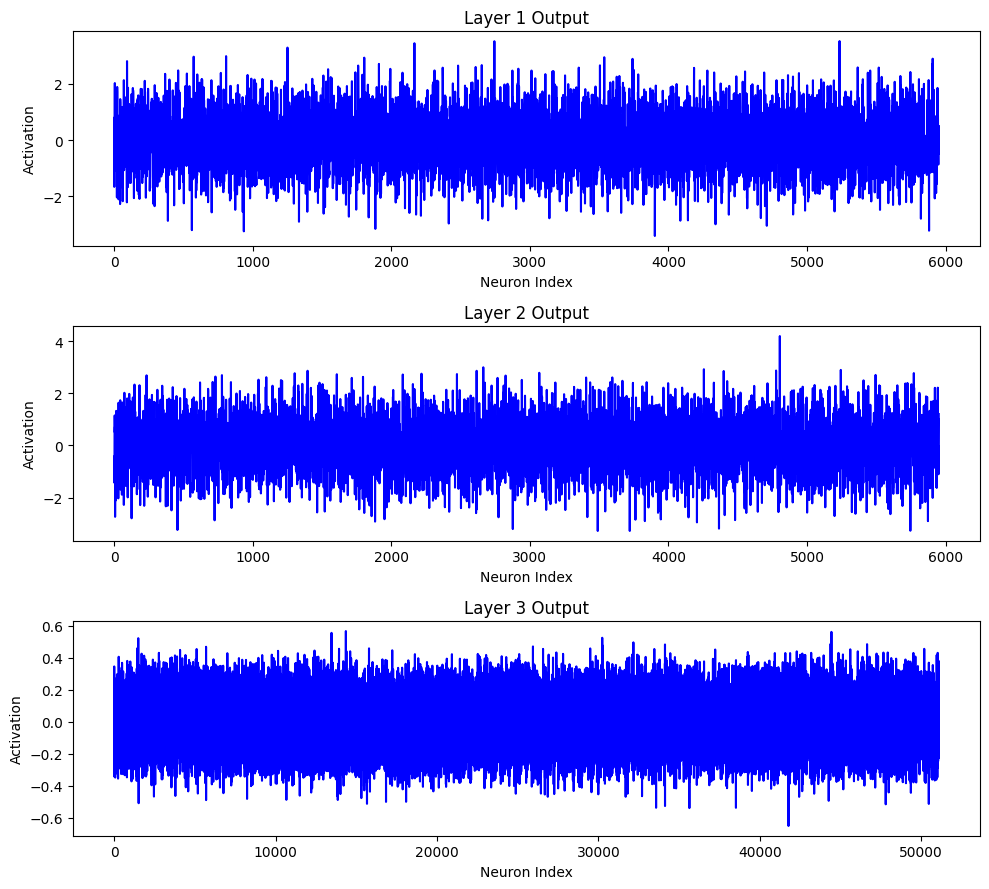

In [16]:
plot_layer_outputs(model, input, target)

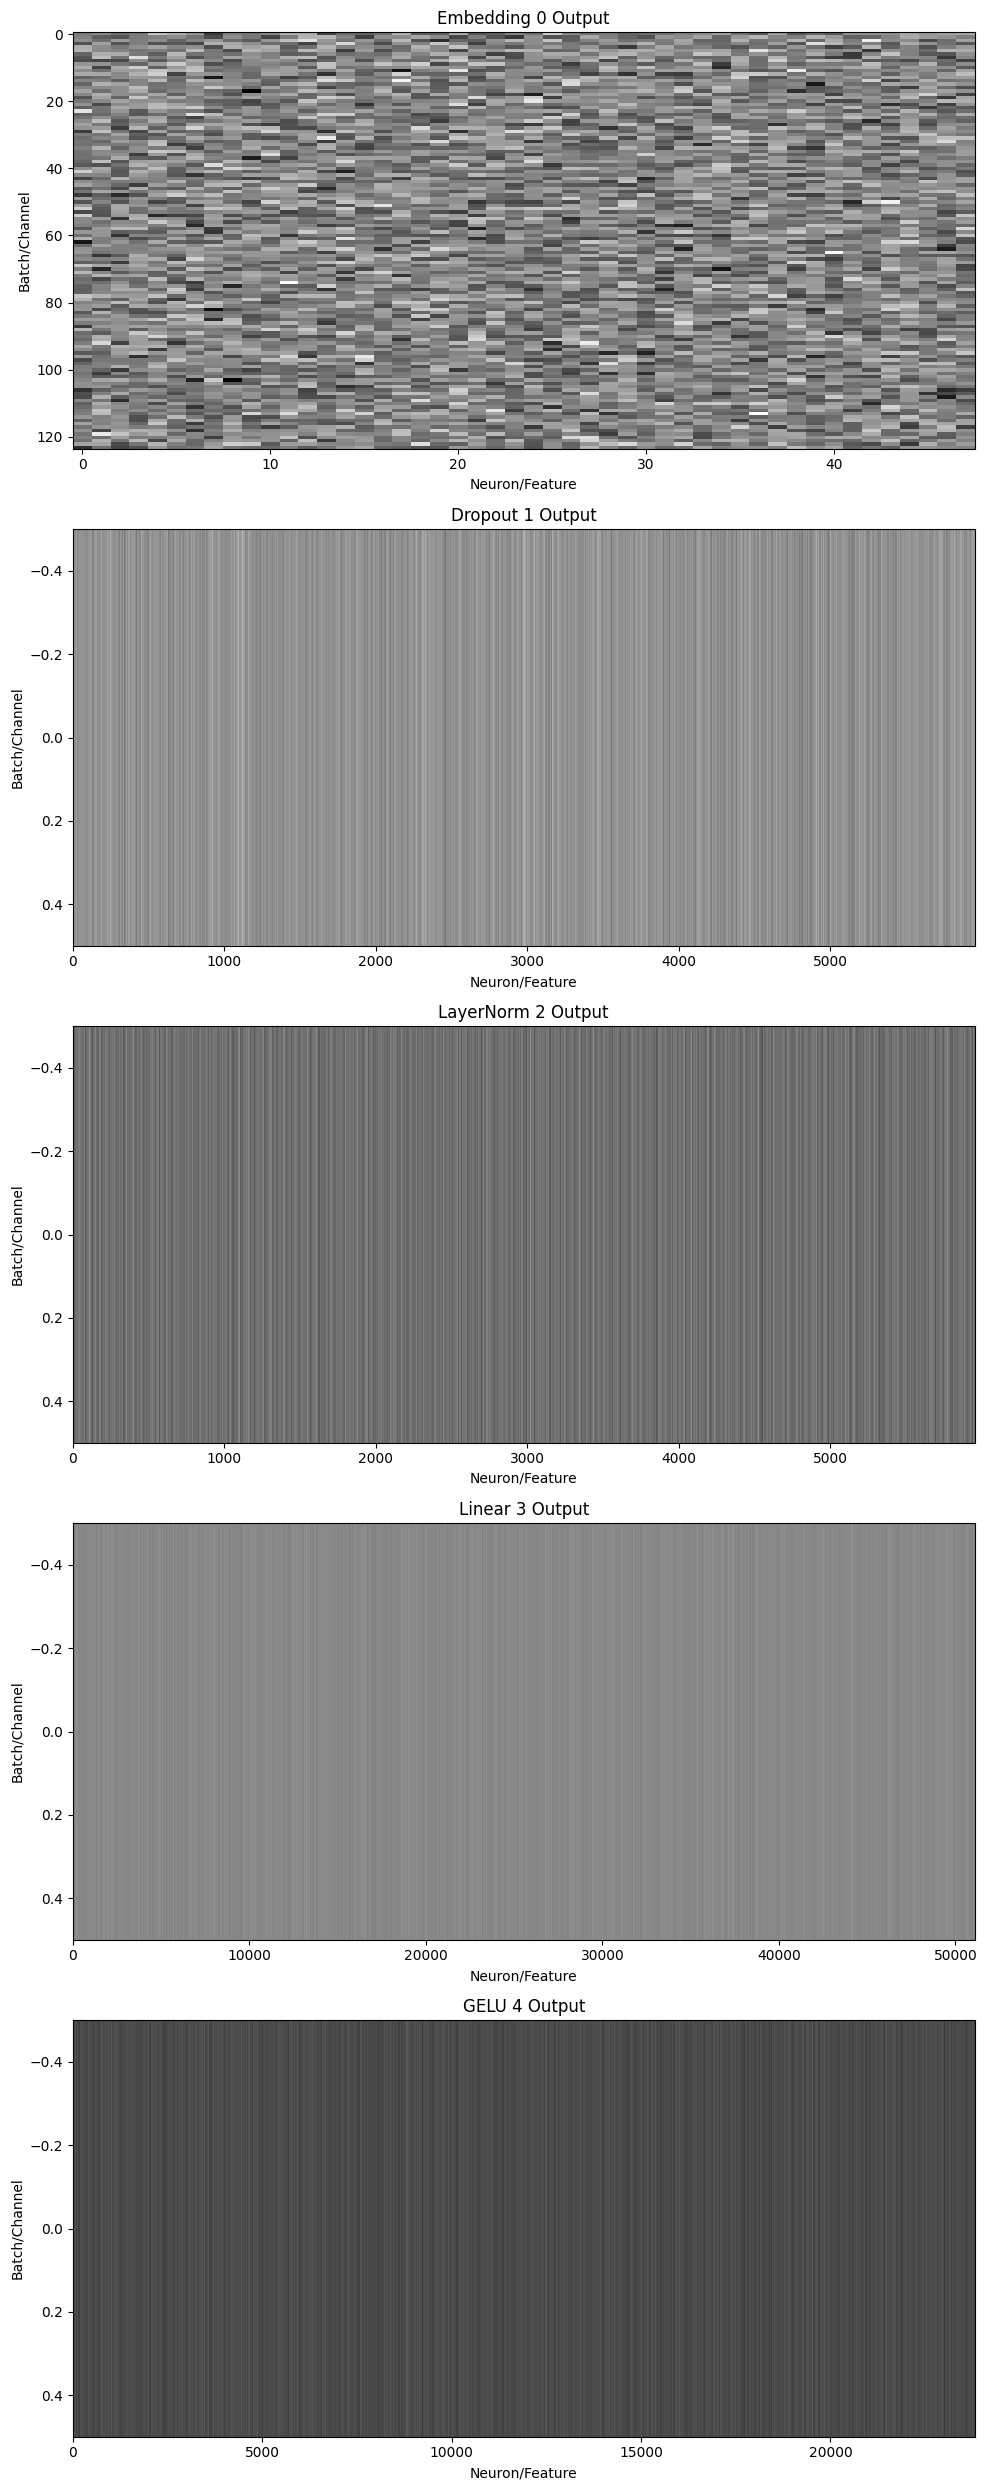

In [17]:
imshow_layer_outputs(model, input, target)

In [35]:
def flatten(model, parent_name=''):
    sep='.'
    """
    Recursively flattens the layers of a PyTorch model.
    Returns a list of dot-separated layer names.
    """
    layer_names = {}
    for name, module in model.named_children():
        full_name = f"{parent_name}{sep}{name}" if parent_name else name
        if len(list(module.named_children())) != 0:
            # Recurse into nested Sequential modules
            layer_names.update(flatten(module, name))
        else:
            layer_names[full_name] = module
    return layer_names

layers = flatten(model)
# 

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in layers.items(): # note: exclude the output layer
  print(i, layer)
  if isinstance(layer, nn.Linear):
    t = layer.out.grad
    print('layer %s (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

encoder.wte Embedding(412, 48)
encoder.wpe Embedding(124, 48)
encoder.drop Dropout(p=0.0, inplace=False)
0.ln_1 LayerNorm()
attn.c_attn Linear(in_features=144, out_features=144, bias=True)


AttributeError: 'Linear' object has no attribute 'out'

<Figure size 2000x400 with 0 Axes>

In [43]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    max_grads = []
    layers = []

    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean())
            max_grads.append(param.grad.abs().max())

    plt.bar(range(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(range(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(len(ave_grads)), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom=-0.001, top=0.02)
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient Flow")
    plt.grid(True)
    plt.legend(["Max Gradient", "Mean Gradient", "Zero Gradient"])

In [47]:
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for i, layer in layers.items(): # note: exclude the output layer
#   if isinstance(layer, nn.Linear):
#     t = layer.data.grad
#     print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
#     hy, hx = torch.histogram(t, density=True)
#     plt.plot(hx[:-1].detach(), hy.detach())
#     legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('gradient distribution')
plot_grad_flow(model.named_parameters())

AttributeError: 'NoneType' object has no attribute 'abs'

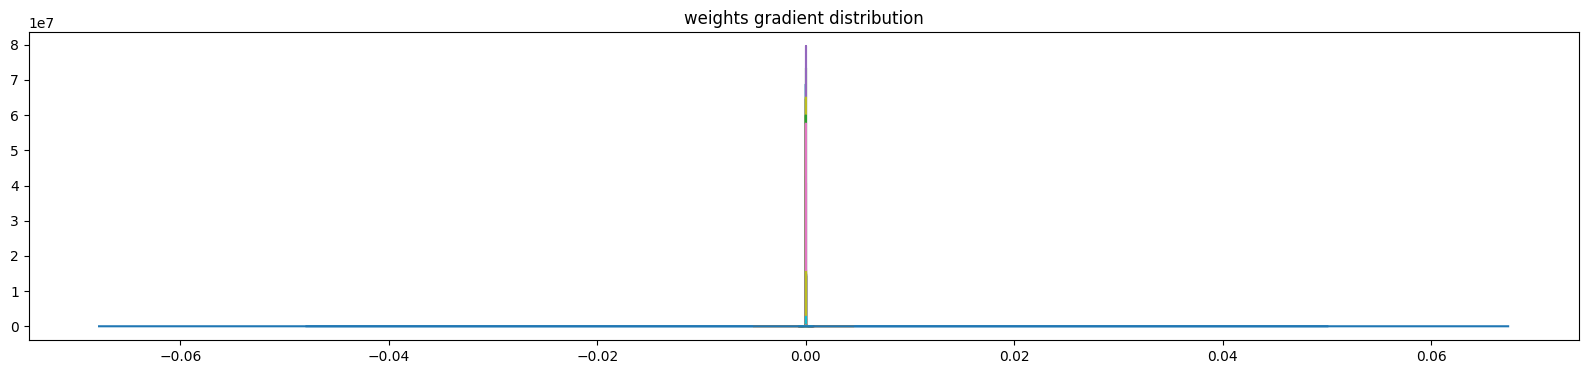

In [34]:
# visualize weight gradient distribution

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2 and p.grad != None:
    # print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(p.grad, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
# plt.legend(legends)
plt.title('weights gradient distribution');